<span style="color:#8000C0"><tt><b> Version 1.30 - 2024, October, 6 <br>
Project : SysTherLin (Systèmes thermiques linéaires)<br>
Copyright (Eric Ducasse 2018)<br>
Licensed under the EUPL-1.2 or later<br>
Institution : ENSAM / I2M </b></tt></span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

* Pour pouvoir importer les classes du code SysTherLin :

In [2]:
import os,sys
rel_sys_ther_lin_path = ".." # Chemin relatif du dossier SysTherLin
abs_sys_ther_lin_path = os.path.abspath(rel_sys_ther_lin_path)
sys.path.append(abs_sys_ther_lin_path)

* Importation des classes du code SysTherLin :

In [3]:
try :
    from Couches_conductrices import CoucheConductrice,Multicouche
    from Systemes_thermiques_lineaires import (Cavite, SystemeThermiqueLineaire)
except Exception as err :
    print(f"Erreur : '{err}'")
    raise ValueError(f"Dossier '{abs_sys_ther_lin_path}' incorrect")

# <span style="color:#C00000;font-size:22px;font-weight:bold">EXEMPLE N°1 : AQUARIUM AVEC UN SYSTÈME DE CHAUFFAGE</span>

## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 1 : Définition des couches conductrices</span>

* Température initiale commune ici à tous les éléments

In [4]:
T0 = 15.0 # °C

* Couche d'inox du socle de l'aquarium

In [5]:
inox = CoucheConductrice(16.5, 8000.0, 500.0, 3.0e-3, T0)
print(inox)

Couche conductrice de paramètres :
	Conductivité : 16.50 W/K/m
	Masse volumique : 8000.00 kg/m³
	Capacité calorique : 500.00 J/K/kg
	Épaisseur : 3.00 mm
	Constante de temps : 1.09 s
	Température initiale : 15.00 °C


* Couche de verre du socle de l'aquarium

In [6]:
verre_socle =  CoucheConductrice(1.0, 2800.0, 1000.0, 4.0e-3, T0)
print(verre_socle)

Couche conductrice de paramètres :
	Conductivité : 1.00 W/K/m
	Masse volumique : 2800.00 kg/m³
	Capacité calorique : 1000.00 J/K/kg
	Épaisseur : 4.00 mm
	Constante de temps : 22.40 s
	Température initiale : 15.00 °C


* Couche de verre des autres parois

In [7]:
verre_coque =  CoucheConductrice(1.0, 2800.0, 1000.0, 8.0e-3, T0)
print(verre_coque)

Couche conductrice de paramètres :
	Conductivité : 1.00 W/K/m
	Masse volumique : 2800.00 kg/m³
	Capacité calorique : 1000.00 J/K/kg
	Épaisseur : 8.00 mm
	Constante de temps : 89.60 s
	Température initiale : 15.00 °C


## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 2 : Définition des multicouches avec conditions aux bords</span>

## <span style="color:#A000A0;font-size:18px">2.1 $-$ Socle avec système de chauffage en dessous</span>

In [8]:
socle = Multicouche([inox, verre_socle])

In [9]:
socle.definir_CL("G", "Neumann") # Côté chauffage

In [10]:
socle.definir_CL("D", "Convection",200.0) # Côté eau (cavité)

In [11]:
print(socle)

Multicouche à 2 couche(s) conductrice(s) 
	d'épaisseur(s) en millimètres : [3.0, 4.0]
	Condition limite à gauche : "Neumann"
	Condition limite à droite : "Convection"


## <span style="color:#A000A0;font-size:18px">2.2 $-$ Toutes les autres parois</span>

In [12]:
coque = Multicouche([verre_coque])

In [13]:
coque.definir_CL("G", "Convection", 200.0) # Côté eau (cavité)

In [14]:
coque.definir_CL("D", "Convection", 10.0) # Côté air extérieur

In [15]:
print(coque)

Multicouche à 1 couche(s) conductrice(s) 
	d'épaisseur(s) en millimètres : [8.0]
	Condition limite à gauche : "Convection"
	Condition limite à droite : "Convection"


## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 3 : Définition des cavités</span>

## <span style="color:#A000A0;font-size:18px">Ici, une seule cavité d'eau de 200 litres</span>

In [16]:
cavite = Cavite(0.2, 1000.0, 4200.0,[(socle,"D",0.4),(coque,"G",1.8)], T0)
print(cavite)

Cavité à 2 parois :
	Volume : 200.00 l
	Masse volumique : 1000.00 kg/m^3
	Capacité calorique : 4200.00 J/K/kg
	Température initiale : 15.00 °C
	Surface de la paroi n°1 : 0.400 m²
	Surface de la paroi n°2 : 1.800 m²


## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 4 : Définition du système global</span>

On spécifie ici la durée et la période d'échantillonnage

In [17]:
jour = 3600.*24
STL = SystemeThermiqueLineaire(4*jour, 10.0, cavite)

## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 5 : Définition des signaux imposés et calcul de la solution</span>

## <span style="color:#A000A0;font-size:18px">5.1 $-$ Chauffage de l'aquarium par le socle</span>

* Définition et test de la fonction du temps

In [22]:
def chauf(t) : # Fonction vectorisée
    h = (t/3600.0)%24.0  # Heure de la journée
    return ((h>23)|(h<4))*500.0 # 500 W/m² s'il est allumé
chauf( np.linspace(0,jour,25) )

array([500., 500., 500., 500.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 500.])

* Définition des instants positifs ou nuls

In [23]:
instants_positifs = STL.positiveTimeValues

* Définition du signal imposé sur le bord gauche du socle

In [24]:
socle.definir_signal("G", chauf(instants_positifs))

## <span style="color:#A000A0;font-size:18px">5.2 $-$ Température extérieure</span>

* Définition et test de la fonction du temps

In [26]:
def T_ext(t, Tinit=T0) :
    # Constantes :
    m,a,j,dp = 5.0, 0.15, 3600.0*24.0, 2.0*np.pi
    # Signal renvoyé
    return Tinit + m*(1-np.cos(dp*t/j-a))
T_ext( np.linspace(0,jour,25) ).round(2)

array([15.06, 15.03, 15.34, 15.98, 16.88, 18.  , 19.25, 20.56, 21.82,
       22.97, 23.91, 24.58, 24.94, 24.97, 24.66, 24.02, 23.12, 22.  ,
       20.75, 19.44, 18.18, 17.03, 16.09, 15.42, 15.06])

* Définition du signal imposé sur le bord droit de la coque

In [27]:
coque.definir_signal("D", T_ext(instants_positifs))

## <span style="color:#A000A0;font-size:18px">5.3 $-$ Calcul de la solution</span>

In [28]:
STL.calculer_maintenant()

SystemeThermiqueLineaire.calculer_maintenant...
... Calcul effectué.


## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 6 : Visualisation des résultats</span>

* Instants en jours pour le tracé des courbes

In [32]:
instants = STL.timeValues
t_en_jours = instants / jour

* Tracé des signaux d'entrée

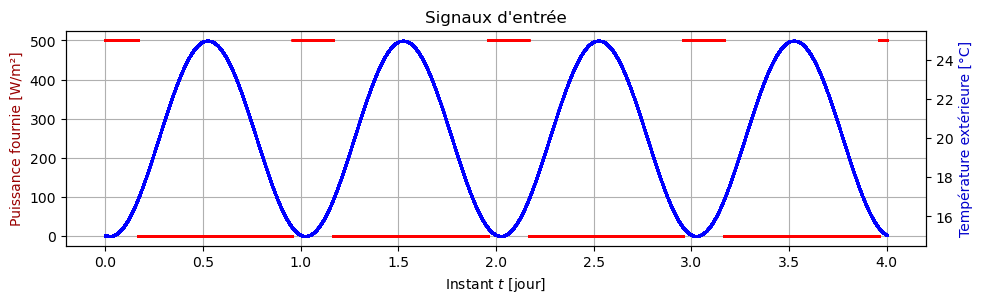

In [36]:
fig_in = plt.figure(figsize=(10,2.5))
ax_input = fig_in.subplots(1,1)
ax_input2 = ax_input.twinx()
ax_input.set_title("Signaux d'entrée")
plt.subplots_adjust(left=0.07, right=0.93, bottom=0.07, top=0.93,
                    wspace=0.4, hspace=0.3)
ax_input.plot(t_en_jours, socle.signal("G"), ".r", markersize=2)
ax_input.set_ylabel("Puissance fournie [W/m²]", color=(0.6,0,0))
ax_input.grid()
ax_input2.plot(t_en_jours, coque.signal("D"), ".b", markersize=2)
ax_input2.set_ylabel("Température extérieure [°C]",color=(0,0,0.8))
ax_input.set_xlabel("Instant $t$ [jour]") ;

* Tracé des réponses calculées

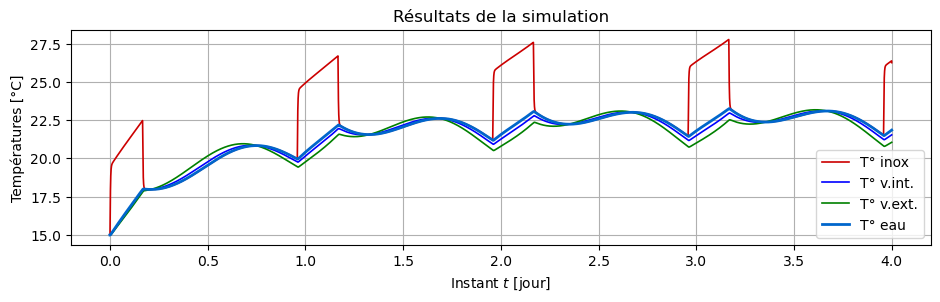

In [38]:
fig_out = plt.figure(figsize=(10,2.5))
ax_output = fig_out.subplots(1,1)
ax_output.set_title("Résultats de la simulation")
plt.subplots_adjust(left=0.07, right=0.93, bottom=0.07, top=0.93,
                    wspace=0.4, hspace=0.3)
# Température au coeur de l'inox du socle
_,T_inox,_ = socle.T_phi(1.5e-3) # milieu de l'inox
ax_output.plot(t_en_jours, T_inox, "-", color=(0.8,0,0),
               linewidth=1.2, label = "T° inox")
# Température des parois de verre
_,T_verre_int,_ = coque.T_phi(coque.X[0]) # intérieur
_,T_verre_ext,_ = coque.T_phi(coque.X[-1]) # extérieur
ax_output.plot(t_en_jours, T_verre_int, "-", color=(0,0,1),
               linewidth=1.2, label = "T° v.int.")
ax_output.plot(t_en_jours, T_verre_ext, "-", color=(0,0.5,0),
               linewidth=1.2, label = "T° v.ext.")
# Température de l'eau dans la cavité
T_cav = STL.T_cavites[0]
ax_output.set_xlabel("Instant $t$ [jour]")
ax_output.plot(t_en_jours, T_cav, "-", color=(0,0.4,0.8),
               linewidth=2.0, label = "T° eau")
# Finalisation du tracé
ax_output.set_ylabel("Températures [°C]")
ax_output.grid()
ax_output.legend(loc="best", fontsize=10) ;